<a href="https://colab.research.google.com/github/wenjian98/lecture-1/blob/main/Week_7_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout



########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("MSFT", start="2010-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 4
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(25))




model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
2439/2439 [==============================] - 6s 2ms/step - loss: 2.1322e-04
Epoch 2/3
2439/2439 [==============================] - 4s 2ms/step - loss: 2.1104e-04
Epoch 3/3
2439/2439 [==============================] - 5s 2ms/step - loss: 2.0989e-04


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




predictions_test = model.predict(x_test)
predictions_train = model.predict(x_train)


77/77 [==============================] - 0s 1ms/step


In [ ]:
test_pred2 = np.array([predictions_test[i][0][0] for i in range(0,predictions_test.shape[0])])
train_pred2 = np.array([predictions_train[i][0][0] for i in range(0,predictions_train.shape[0])])

In [ ]:
# insample Accurracy
print("RMSE_insample:", np.sqrt(np.mean(train_pred2-y_train)**2))

# insample random walk assumption Accuracy
print("insample_rw:", np.mean(y_train))

RMSE_insample: 0.0002721796728886658
insample_rw: 0.0007230299244250415


In [ ]:
# outsample Accurracy
print("RMSE_outsample:", np.sqrt(np.mean(test_pred2-y_test)**2))

# outsample random walk assumption Accuracy
print("outsample_rw:", np.sqrt(np.mean(test_pred2-y_test)**2))

RMSE_outsample: 0.0009597863942078842
outsample_rw: 0.0014087563262468927


<BarContainer object of 4 artists>

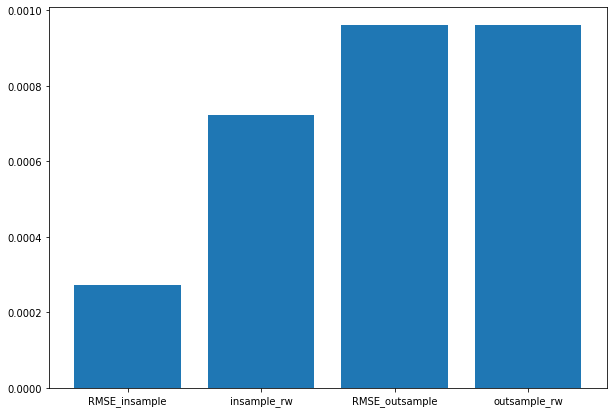

In [ ]:
accuracy = ['RMSE_insample',"insample_rw","RMSE_outsample","outsample_rw"]
values=[np.sqrt(np.mean(train_pred2-y_train)**2),np.mean(y_train),np.sqrt(np.mean(test_pred2-y_test)**2),np.sqrt(np.mean(test_pred2-y_test)**2)]


fig = plt.figure(figsize =(10, 7))
plt.bar(accuracy, values)

# 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(-1,1) * np.cumprod(y_test+1)



20/20 [==============================] - 0s 1ms/step


In [ ]:
train_predict = model.predict(x_train)



77/77 [==============================] - 0s 1ms/step


In [ ]:
train_predictions = (train_predict+1).reshape(-1,1) * np.cumprod(y_train+1)


20/20 [==============================] - 0s 2ms/step


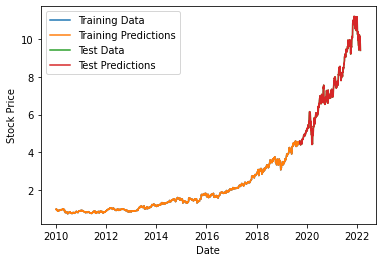

In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(-1,1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

Out-of Sample Evaluation beats random walk 2 fold in out of sample

in Sample Evaluation beats random walk 3 fold in sample


the prediction is very close the actual data, this is great.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from matplotlib.lines import ls_mapper
from sklearn.model_selection import GridSearchCV, cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor


In [ ]:

# Define the Keras model
###Edit here to create your optimizer
def create_model_5():
    model = Sequential()
    model.add(LSTM(5, dropout=0.2, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

def create_model_10():
    model = Sequential()
    model.add(LSTM(10, dropout=0.2, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

def create_model_20():
    model = Sequential()
    model.add(LSTM(20, dropout=0.2, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

model1 = KerasRegressor(build_fn=create_model_5, verbose=0)
model1.fit(x_train, y_train)
model2 = KerasRegressor(build_fn=create_model_10, verbose=0)
model2.fit(x_train, y_train)
model3 = KerasRegressor(build_fn=create_model_20, verbose=0)
model3.fit(x_train, y_train)


<ipython-input-112-ec74e89e333c>:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model1 = KerasRegressor(build_fn=create_model_5, verbose=0)
<ipython-input-112-ec74e89e333c>:27: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model2 = KerasRegressor(build_fn=create_model_10, verbose=0)
<ipython-input-112-ec74e89e333c>:29: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model3 = KerasRegressor(build_fn=create_model_20, verbose=0)


In [ ]:
print("lag_5:",np.mean(cross_val_score(model1,x_train, y_train, cv=3, scoring='neg_mean_squared_error')))
print("lag_10:",np.mean(cross_val_score(model2,x_train, y_train, cv=3, scoring='neg_mean_squared_error')))
print("lag_20:",np.mean(cross_val_score(model3,x_train, y_train, cv=3, scoring='neg_mean_squared_error')))

lag_5: -0.2057536414614868
lag_10: -0.18375085685882295
lag_20: -0.14604176569740082
